# lr_scheduler 理解

In [112]:
from bisect import bisect_right
import math
import matplotlib.pyplot as plt
import torch

In [239]:
from detectron2.solver import WarmupCosineLR, WarmupMultiStepLR

In [323]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = WarmupMultiStepLR(optimizer, [60000,80000])

1e-06 0.0001009


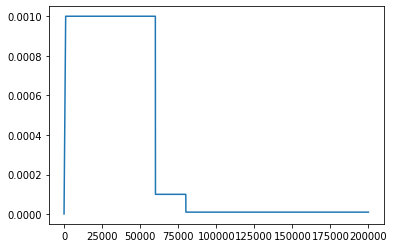

In [324]:
class NullModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(1,1)
    

model = NullModule()

def plot_lr(scheduler, step=200000):
    lrs = []
    for i in range(step):
        lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        lrs.append(lr)
    print(lrs[0], lrs[100])
    plt.plot(lrs)
    plt.show()
plot_lr(scheduler)

In [292]:
def _get_warmup_factor_at_iter(
    method: str, iter: int, warmup_iters: int, warmup_factor: float
) -> float:
    """
    Return the learning rate warmup factor at a specific iteration.
    See :paper:`ImageNet in 1h` for more details.

    Args:
        method (str): warmup method; either "constant" or "linear".
        iter (int): iteration at which to calculate the warmup factor.
        warmup_iters (int): the number of warmup iterations.
        warmup_factor (float): the base warmup factor (the meaning changes according
            to the method used).

    Returns:
        float: the effective warmup factor at the given iteration.
    """
    if iter >= warmup_iters:
        return 1.0

    if method == "constant":
        return warmup_factor
    elif method == "linear":
        alpha = iter / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    else:
        raise ValueError("Unknown warmup method: {}".format(method))

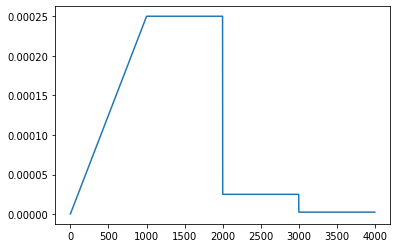

In [328]:
base_lr = 0.00025
warmup_factor = 1.0 / 1000
warmup_iters = 1000
gamma=0.1
def step_lr(step):
    warmup_factor1 = _get_warmup_factor_at_iter('linear', step, warmup_iters=warmup_iters, warmup_factor=warmup_factor)
    #milestones, <1000(第一个mile stone) warmup起作用,这时候gamma**0, 所以只有warmup项! 
    # >1000后, milestone开始起作用, 每一个milestone后开始按gamma指数减少!
    return base_lr * warmup_factor1 * gamma ** bisect_right([2000, 3000], step) 
lrs = [step_lr(step) for step in range(0, 4000)]
plt.plot(lrs)

# data.transform

In [ ]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
    T.RandomCrop("absolute", (640, 640))
])  # type: T.Augmentation

# Define the augmentation input ("image" required, others optional):
input = T.AugInput(image, boxes=boxes, sem_seg=sem_seg)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = input.image  # new image
sem_seg_transformed = input.sem_seg  # new semantic segmentation

# For any extra data that needs to be augmented together, use transform, e.g.:
image2_transformed = transform.apply_image(image2)
polygons_transformed = transform.apply_polygons(polygons)

# engine--done


# evaluation--done-rough

# export--not-done

# layers--done-rough

# modeling--need-to-be-done-in-great-detail

In [338]:
from typing import *

In [339]:
def _create_grid_offsets(size: List[int], stride: int, offset: float, device: torch.device):
    grid_height, grid_width = size
    shifts_x = torch.arange(
        offset * stride, grid_width * stride, step=stride, dtype=torch.float32, device=device
    )
    shifts_y = torch.arange(
        offset * stride, grid_height * stride, step=stride, dtype=torch.float32, device=device
    )

    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    return shift_x, shift_y

In [374]:
_create_grid_offsets((1,2), 4, 0, 'cpu')

(tensor([0., 4.]), tensor([0., 0.]))